**Задача 1**  
Модифицируйте логирование, чтобы выводились не пошаговые значения потерь, а средние значения за эпоху.  
**Задача 2**  
Написать код, который отображает 5 случайных изображений из датасета с нарисованными bounding boxes и подписями классов.

In [1]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets==0.5
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━

In [2]:
import torch
import glob
from torch_snippets import *

In [3]:
DATA_ROOT = '/content/open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = DF_RAW.copy()
df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]
label2target = {l: t+1 for t, l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t: l for l, t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir + '/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR)) / 255.
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin', 'YMin', 'XMax', 'YMax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device) / 300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels

    def __len__(self):
        return len(self.image_infos)

In [5]:
imgs_0 = glob.glob(f'{DATA_ROOT}/images/*')
imgs_0[:3]

['/content/open-images-bus-trucks//images/bd2b6654321bf247.jpg',
 '/content/open-images-bus-trucks//images/f47d3cc48ae23ef9.jpg',
 '/content/open-images-bus-trucks//images/6b62e1eab2c5be1f.jpg']

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=16,  # batch size увеличен до 16 для ускорения обучения
                          collate_fn=train_ds.collate_fn,
                          drop_last=False)
test_loader = DataLoader(test_ds, batch_size=16,   # batch size увеличен до 16 для ускорения обучения
                         collate_fn=test_ds.collate_fn,
                         drop_last=False)

[04/11/25 09:42:09] INFO     13702 items loaded                          ]8;id=26885;file://<ipython-input-4-c64ff76957a4>\<ipython-input-4-c64ff76957a4>]8;;\:]8;id=640548;file://<ipython-input-4-c64ff76957a4>#__init__:25\__init__:25]8;;\

                    INFO     1523 items loaded                           ]8;id=256982;file://<ipython-input-4-c64ff76957a4>\<ipython-input-4-c64ff76957a4>]8;;\:]8;id=289626;file://<ipython-input-4-c64ff76957a4>#__init__:25\__init__:25]8;;\

In [7]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [8]:
from model import SSD300, MultiBoxLoss
from detect import *

In [9]:
from torch_snippets import Report

n_epochs = 2  # число эпох изменено на 2
model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 3

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.6MB/s]



Loaded base model.



/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
# Модифицированный цикл обучения: вычисляются средние потери за эпоху
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss_sum = 0.0
    train_batches = 0

    for ix, inputs in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{n_epochs} - Train'):
        loss = train_batch(inputs, model, criterion, optimizer)
        train_loss_sum += loss.item()
        train_batches += 1

    avg_train_loss = train_loss_sum / train_batches if train_batches > 0 else 0.0

    val_loss_sum = 0.0
    val_batches = 0

    for ix, inputs in tqdm(enumerate(test_loader), total=len(test_loader), desc=f'Epoch {epoch+1}/{n_epochs} - Val'):
        loss = validate_batch(inputs, model, criterion)
        val_loss_sum += loss.item()
        val_batches += 1

    avg_val_loss = val_loss_sum / val_batches if val_batches > 0 else 0.0

    log.record(epoch + 1, trn_loss=avg_train_loss, val_loss=avg_val_loss)  # запись средних потерь за эпоху

Epoch 1/2 - Val: 100%|██████████| 96/96 [00:31<00:00,  3.05it/s]


EPOCH: 1.000  trn_loss: 3.835  val_loss: 3.313  (613.50s - 613.50s remaining)


Epoch 2/2 - Val: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]

EPOCH: 2.000  trn_loss: 2.905  val_loss: 2.776  (1217.08s - 0.00s remaining)


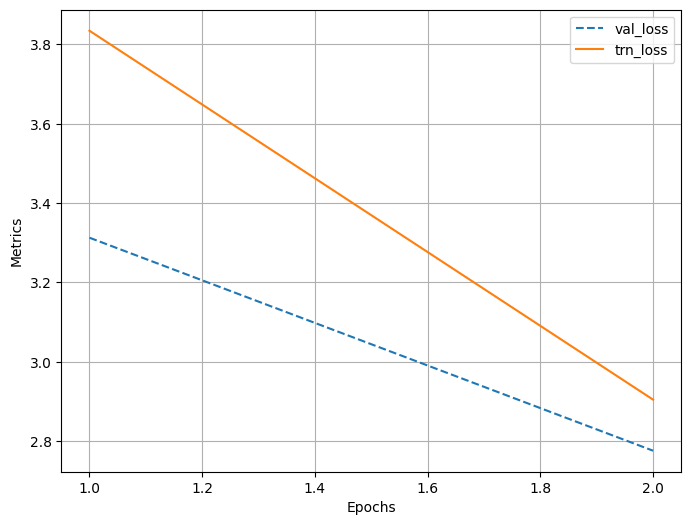

In [11]:
train_losses = log.history('trn_loss')
val_losses = log.history('val_loss')

log.plot()

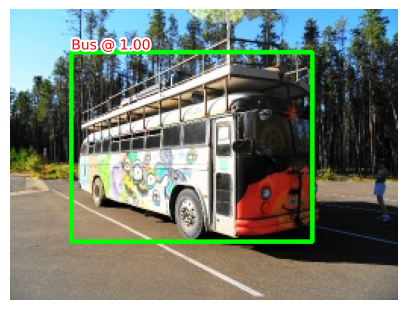

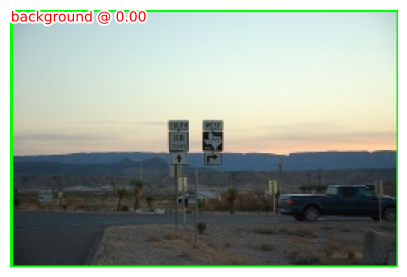

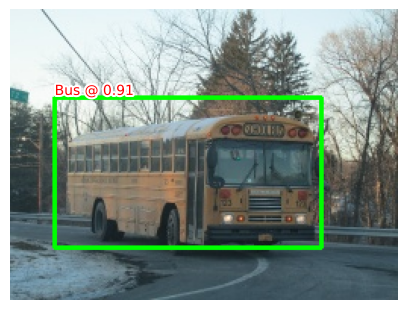

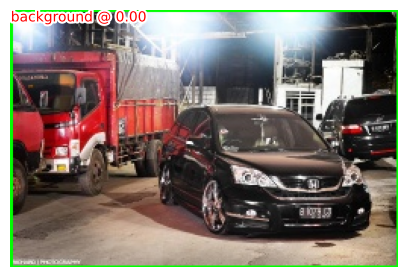

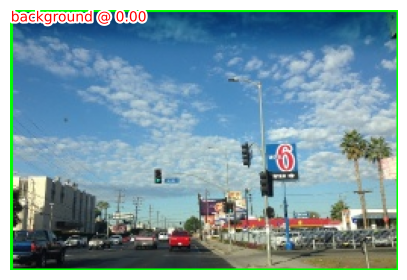

In [12]:
import random
# Ячейка для отображения 5 случайных изображений из тестового датасета с отрисованными bounding boxes и подписями классов
random_ids = random.sample(list(test_ds.image_infos), 5)
for image_id in random_ids:
    img_path = find(image_id, test_ds.files)
    image = Image.open(img_path).convert("RGB")
    bbs, labels, scores = detect(image,
                                 model,
                                 min_score=0.9,
                                 max_overlap=0.5,
                                 top_k=200,
                                 device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l, s in zip(labels, scores)]
    show(image, bbs=bbs, texts=label_with_conf, text_sz=10)